In [2]:
import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '4'
import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import haiku as hk

In [3]:
import metaaf

# %load_ext autoreload
# %autoreload 2

## 制作数据集

When you make a metaaf dataset, you write a vanilla pytorch dataset. The dataset should not use jax and must return a dictionary with the keys "signals" and "metadata". We enforce this format since the "signals" are automatically segmented and buffered. In this example, we make a simple system identification dataset which returns signals but not metadata.

这里通过Pytorch的`dataset`方法构造metaaf的数据集。

**注意**：数据集不能使用`jax`且必须返回一个包含`signals`和`metadata`的字典。为了实现字典数据返回格式，`signals`将会被自动分段和缓冲。

In [4]:
from torch.utils.data import Dataset

# 构造pytorch数据集
class SystemIDDataset(Dataset):
    def __init__(self, total_size=1024, N=4096, sys_order=32):
        self.N          = N
        self.sys_order  = sys_order
        self.total_size = total_size

    def __len__(self):
        return self.total_size

    def __getitem__(self, idx):
        # 系统构造，其实不同的系统就是设计不同的滤波器系数矩阵w
        w = np.random.normal(size=self.sys_order) / self.sys_order

        # 系统输入信号u，即滤波器的输入
        u = np.random.normal(size=self.N)

        # 输出：系统输出信号d，即期望的目标响应(target or desired response)
        # 通过np.convole方法返回线性离散1D卷积序列
        d = np.convolve(w, u)[: self.N]

        # meta自适应滤波数据集返回一个包含如下内容的字典：
        # （1）"signals"：该信号会被自动添加到缓冲器
        # （2）"metadata"：由用户自行管理
        return {
            "signals": {
                "u": u[:, None],    # 自适应滤波器的输入
                "d": d[:, None],    # 期望的响应输出
            },
            "metadata": {},
        }

## 制作滤波器

滤波器是用来适应输入信号的。Metaaf为各种常见的STFT处理管道提供了封装好的代码：`Overlap-Save`、`Overlap-Add`和`Weighted Overlap-Add`。另外，通过`buffering`框架，我们也可以构建自己的滤波器。

所有的滤波器都是在`haiku`库中编写的。当使用封装好的代码，滤波器必须返回一个包含`out`键的字典，它是后续STFT处理需要的数据。

In [5]:
from metaaf.filter import OverlapSave

# 滤波器继承于overlap save modules
class SystemID(OverlapSave, hk.Module):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        # 选择分析窗：
        # 这里的self.window_size是OverlapSave中的类变量，由于这里构造的滤波器
        # 继承于OverlapSave,所以可以直接定义self.window_size
        self.analysis_window = jnp.ones(self.window_size)

    # 由于我们使用的是OLS基类，x和y是stft域的输入
    # 因此，The filter msut take the same inputs provided in its _fwd function.
    def __ols_call__(self, u, d, metadata):
        # Collect a buffer size anti-aliased filter
        # 使用get_filter方法构造滤波器
        w = self.get_filter(name="w")

        # 系统估计响应（extimated response）y和系统误差e
        # this is n_frames x n_freq x channels or 1 x F x 1 here
        y = w * u
        e = y - d

        return {
            "out" : y[0],
            "u"   : u,
            "d"   : d,
            "e"   : e,
            "loss": jnp.vdot(e, e).real / (e.size), # The MSE of the prediction
        }

# 为此下面提供一个封装的包，以实现通过Haiku包将对象转换为函数。
# 封装的函数必须从数据集中获取相同命名作为输入
def _SystemID_fwd(u, d, metadata=None, init_data=None, **kwargs):
    gen_filter = SystemID(**kwargs)
    return gen_filter(u=u, d=d)

# 我们还需要定义滤波器的损失
def filter_loss(out, data_samples, metadata):
    return out["loss"]

# 同时我们还需要定义meta损失
def meta_loss(losses, outputs, data_samples, metadata, outer_leanable):
    EPS = 1e-9
    return jnp.log(jnp.mean(jnp.abs(outputs - data_samples["d"]) ** 2) + EPS)

## 初始化Meta训练

Next, we setup all filter keyword arguments. These will be used by the OLS baseclass to correctly buffer inputs and run the online STFT processing. These can also be done via argparse, since all metaaf modules have argparse utilities. Here, we use dictionaries for simplicity.

**设置所有滤波器的关键字参数：**

这些参数将被用于OLS基类输入的准确缓存以及在线STFT的处理。由于所有`MetaAF`模块都具有`argparse`工具包，因此，这些操作是通过`argparse`完成的。为了简单起见，这里使用字典形式的数据。

In [6]:
from metaaf.data import NumpyLoader

# 所有滤波器的初始化参数，这些参数将被用于STFT的处理参数
filter_kwargs = {
    "n_frames"   : 1,
    "n_in_chan"  : 1,
    "n_out_chan" : 1,
    "window_size": 64,
    "hop_size"   : 32,
    "pad_size"   : 0,
    "is_real"    : True,
}

# 优化器参数
optimizer_kwargs = {
    "h_size"         : 16,
    "n_layers"       : 1,
    "lam_1"          : 1e-2,
    "input_transform": "log1p",
}

# 使用封装好的NumpyLoader类包，初始化训练需要的dataloader数据
train_loader = NumpyLoader(SystemIDDataset(total_size=1024), batch_size=16)
val_loader   = NumpyLoader(SystemIDDataset(total_size=128), batch_size=32)
test_loader  = NumpyLoader(SystemIDDataset(total_size=128), batch_size=32)

Now, we create a metaaf system. This system manages the training and will later provide inference utilities. We need to pass it the forward functions, losses, keyword arguments as well as the dataloaders. We'll set some optimizer options. For more advanced functionality, we can write our own forward passes, overridde other options, and even pass in training callbacks. These could do things like save checkpoints, log outputs, and more.

现在，**创建一个`MetaAF`系统：**

下面的系统用于管理着MetaAF的训练过程以及为后续提供inference utilities。并将前向传播函数（forward function）、损失（losses）、关键字参数（keyword arguments）和dataloader数据传入MetaAF系统。

为了简单起见，我们将设置一些优化器选项（optimizer options），以便设计更加高级的功能。通过优化器选项，我们可以编写自定义的前向传递过程，甚至传递训练回调。进一步，还可以执行保存检查点、日志输出操作。

In [7]:
from metaaf.meta import MetaAFTrainer

# 创建MetaAF系统
system = MetaAFTrainer(
    _filter_fwd      = _SystemID_fwd,    # 通过_SystemID_fwd函数构造系统的前向传播函数，用于滤波器的构造
    filter_kwargs    = filter_kwargs,    # 所有滤波器的参数
    filter_loss      = filter_loss,      # 滤波器的损失函数
    meta_train_loss  = meta_loss,        # meta训练损失函数
    meta_val_loss    = meta_loss,        # meta验证损失函数
    optimizer_kwargs = optimizer_kwargs, # 优化器参数
    train_loader     = train_loader,     # 训练数据集
    val_loader       = val_loader,       # 验证数据集
    test_loader      = test_loader,      # 测试数据集
)

## 训练

Finally, we can train the system. Simply run system.train and pass in training parameters such as the optimizer, learning rate, early stopping information, and more.

**MetaAF训练：**

调用`system.train()`函数并传入训练参数，比如优化器、学习率、提前停止信息等即可。

In [8]:
key = jax.random.PRNGKey(0)
key, subkey = jax.random.split(key)

# 计算MetaAF系统的训练模型参数outer_learned，以及训练损失（train_loss）和验证损失(val_loss)
outer_learned, (train_loss, val_loss) = system.train(
    total_epochs=21, val_period=10, key=subkey
)

Total of - 1905 - Trainable Parameters


Epoch Loss:-6.95267: 100%|██████████| 21/21 [06:01<00:00, 17.20s/it]


In [9]:
# 查看MetaAF系统的训练模型参数outer_learned数据结构信息
print(type(outer_learned))

outer_learned.keys()
outer_learned.values()

<class 'dict'>


dict_values([{'ElementWiseGRU/~/cgru': {'b': DeviceArray([ 0.3444199 +3.4441990e-01j,  0.32596925+3.2596925e-01j,
              0.3527564 +3.5275641e-01j,  0.05230173+5.2301731e-02j,
              0.6085891 +6.0858911e-01j,  0.16958858+1.6958858e-01j,
              0.4048098 +4.0480980e-01j,  0.21726456+2.1726456e-01j,
              0.19625655+1.9625655e-01j,  0.34162614+3.4162614e-01j,
              0.16333842+1.6333842e-01j,  0.00497505+4.9750535e-03j,
              0.35410032+3.5410032e-01j,  0.2841221 +2.8412211e-01j,
              0.33879983+3.3879983e-01j,  0.1701364 +1.7013641e-01j,
              0.0257334 +2.5733402e-02j,  0.00915382+9.1538159e-03j,
              0.0344344 +3.4434397e-02j,  0.07074927+7.0749268e-02j,
              0.14513937+1.4513937e-01j,  0.07936186+7.9361863e-02j,
             -0.02034016-2.0340161e-02j,  0.04277634+4.2776335e-02j,
             -0.05497683-5.4976828e-02j,  0.01727768+1.7277682e-02j,
              0.00215833+2.1583294e-03j,  0.09840916+9.840

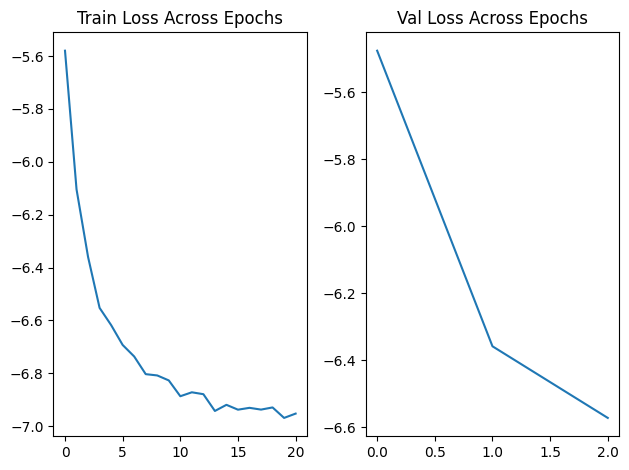

In [10]:
# 绘制结果图
fig, ax = plt.subplots(1, 2)
ax[0].plot(train_loss.mean(1))
ax[0].set_title("Train Loss Across Epochs")

ax[1].plot(val_loss)
ax[1].set_title("Val Loss Across Epochs")

plt.tight_layout()
plt.show()

## 使用训练好的模型

### 线下模型

Once training has finished, the autodsp system has functionality for both batch and online inference. For batch inference, we can just use the system.infer function and pass in the current data as well as the final learned parameters. It will return the predictions as well as other auxilliary outputs like losses, additional filter outputs, and the final filter state.

训练完成后，`autodsp`系统就具有了批量和在线推理功能了。对于批量推理，我们只需要使用`system.infer`函数并传递当前数据以及最终学习的参数即可。它将返回预测以及其他附加输出，如输出损耗、附加滤波器输出和最终滤波器状态。

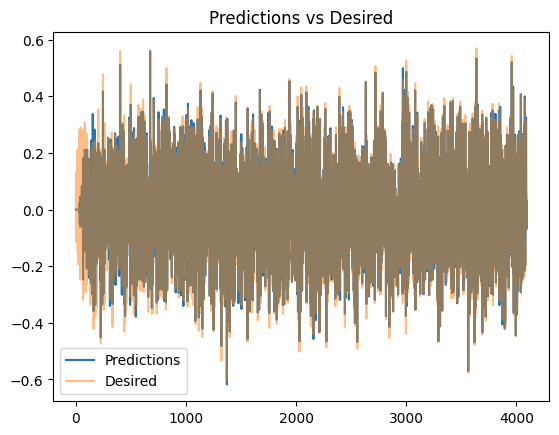

In [11]:
# 使用next方法读取MetaAF系统的验证数据集val_loader的一组数据，并存储到data变量中
data = next(iter(system.val_loader))

# 读取data中的滤波器输入数据u和期望的响应输出d，并以字典格式存储到data_dict中。
# 存储成字典的原因是封装的函数识别的数据为这种字典格式的数据。
data_dict = {"u": data["signals"]["u"][0:1], "d": data["signals"]["d"][0:1]}

# 使用system.infer方法进行线下模型预测，预测结果offline_pred和附加输出aux
offline_pred, aux = system.infer({"signals": data_dict, "metadata": {}}, outer_learned)

# 预测的附加输出包括outer_loss（目前还不理解其具体内涵）、inner_loss（目前还不理解其具体内涵）、
# 附加滤波器输出（extra_outs）、最终状态（final_state）
outer_loss, inner_loss, extra_outs, final_state = aux

# 绘制线下模型预测结果
plt.plot(offline_pred[0, :, 0], label="Predictions")
plt.plot(data_dict["d"][0, :, 0], alpha=0.5, label="Desired")
plt.legend()
plt.title("Predictions vs Desired")
plt.show()

### 线上模型

For online inference, the metaaf system can generate an online_step function and an initial state. We can use this online_step function by passing in hop_size inputs chunks form some audio buffer.

对于在线推理，MetaAF系统可以生成`online_step`函数和初始状态`state`。我们可以通过传递来自某个音频缓冲区的`hop_size`输入块来使用这个`online_step`函数。

In [12]:
print(type(system))

<class 'metaaf.meta.MetaAFTrainer'>


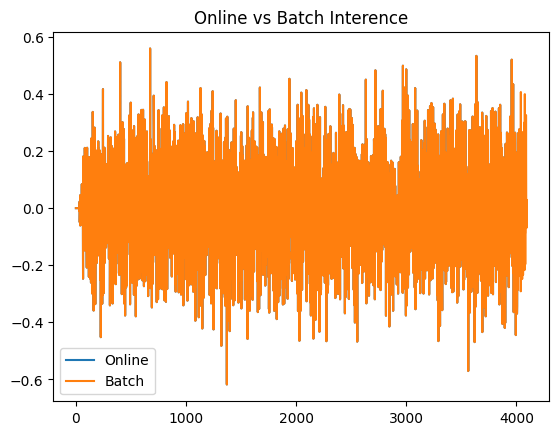

In [16]:
# 以MetaAF系统的训练模型参数outer_learned为输入参数，调用MetaAFTrainer的
# make_online_infer类方法获取online_step函数和MetaAF系统的初始状态state
online_step, state = system.make_online_infer(outer_learned)

# 从设置的滤波器参数filter_kwargs字典中获得hop_size参数
hop_size = filter_kwargs["hop_size"]

# 在线预测结果
preds = []

for i in range(0, len(data["signals"]["u"][0]) - 2 * hop_size, hop_size):
    cur_data = {
        "signals": {
            "u": data["signals"]["u"][0, i : i + hop_size],
            "d": data["signals"]["d"][0, i : i + hop_size],
        },
        "metadata": {},
    }

    # 
    pred, loss, state = online_step(state, batch=cur_data, key=jax.random.PRNGKey(0))
    preds.append(pred["out"])

preds = np.array(preds).flatten()

# 绘制结果
plt.plot(preds, label="Online")
plt.plot(offline_pred[0, :, 0], label="Batch")
plt.title("Online vs Batch Interence")
plt.legend()
plt.show()

### 检测滤波器参数

我们还可以检查过滤器参数。这里，我们将最终过滤器与真实系统一起绘制。

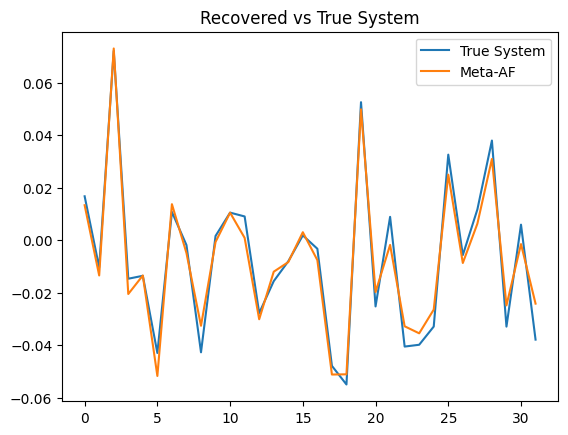

In [28]:
# 随机生成一个滤波器w用作真是系统
w = np.random.normal(size=32) / 32

# 随机生成一个滤波器输入u
u = np.random.normal(size=2048)

# 预期的输出
d = np.convolve(w, u)[: len(u)]

# 下面代码的u[None, :, None]将一维的数据扩展为1 x len(u) x 1的形状，d也同理
data_dict = {"u": u[None, :, None], "d": d[None, :, None]}

offline_pred, aux = system.infer({"signals": data_dict, "metadata": {}}, outer_learned)
outer_loss, inner_loss, extra_outs, final_state = aux

w_hat = jnp.fft.irfft(jax.tree_util.tree_flatten(final_state[1])[0][0][0][0, :, 0])
w_hat = w_hat[: len(w_hat) // 2]

plt.plot(w, label="True System")
plt.plot(w_hat, label="Meta-AF")
plt.title("Recovered vs True System")
plt.legend()
plt.show()


In [54]:
for x in final_state:
    print("元组的第{i}个元素", x)

len(final_state)

元组的第{i}个元素 {'Filter': {'d': DeviceArray([[[ 1.52428135e-01],
              [ 1.07603967e-01],
              [ 2.44082212e-01],
              [-1.55265480e-01],
              [ 5.72855212e-02],
              [-1.54589236e-01],
              [ 3.64158414e-02],
              [-2.15557754e-01],
              [ 1.74421147e-02],
              [ 1.41441450e-01],
              [-5.38221374e-02],
              [ 1.00871496e-01],
              [-1.87880307e-01],
              [ 2.07501784e-01],
              [-8.38663504e-02],
              [ 4.38957214e-02],
              [-4.38899994e-01],
              [-1.54568935e-02],
              [ 7.12163225e-02],
              [ 1.25757948e-01],
              [ 2.66562384e-02],
              [-7.77802914e-02],
              [ 1.25624985e-01],
              [ 1.53308332e-01],
              [ 6.16480902e-05],
              [ 3.77868079e-02],
              [-1.65527567e-01],
              [ 2.34289214e-01],
              [-2.02036858e-01],
              [

5

In [36]:
type(final_state)
jax.tree_util.tree_flatten(final_state[1])

([DeviceArray([[[[-0.14227866-0.05891686j],
                 [ 0.04173666+0.3105715j ],
                 [ 0.06122315-0.00578206j],
                 [ 0.0268503 -0.04644924j],
                 [ 0.04608398+0.05914532j],
                 [ 0.11556147+0.00948257j],
                 [ 0.01286705-0.05442946j],
                 [ 0.18501274-0.04571231j],
                 [-0.07964481-0.18729523j],
                 [ 0.07051788+0.08306374j],
                 [-0.00163484-0.2963222j ],
                 [-0.02518543-0.12027784j],
                 [-0.05122119+0.16295232j],
                 [ 0.03597313-0.1508296j ],
                 [-0.03772186-0.34020537j],
                 [-0.08071066+0.0562356j ],
                 [-0.05163777+0.23286118j],
                 [-0.05487568+0.14776751j],
                 [-0.03891136+0.14772806j],
                 [-0.07622682+0.18177962j],
                 [-0.0338545 +0.2219354j ],
                 [-0.01281879-0.24379314j],
                 [-0.08740326-0.